In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dataset
from finetune import PrunningFineTuner
from ModifiedModels import ModifiedVGG16
import time
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_dir = "Cat_Dog_data/"
train_path = dataset_dir+"train"
test_path = dataset_dir+"test"

In [4]:
#load the training and tet dataset
train_data_loader = dataset.loader(train_path, size = 224)
test_data_loader = dataset.test_loader(test_path, size = 224)

In [5]:
#Create a modified VGG16
vgg16 = ModifiedVGG16().to(device)

In [18]:
vgg16.eval()

ModifiedVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [20]:
epoches = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.0001, momentum=0.9)

In [21]:
def train(model, optimizer, epoches, train_data_loader, test_data_loader, device ):
    
    for i in range(epoches):
        print("Epoch: ", i, end="  ")
        for i, (batch, label) in enumerate(train_data_loader):
            
            batch = batch.to(device)
            label = label.to(device)
            model.zero_grad()
            batch = Variable(batch)
            criterion(model(batch), Variable(label)).backward()
            optimizer.step()
        
        test(model, test_data_loader, device)

In [22]:
def test(model, test_data_loader, device):
    model.eval()
    correct = 0
    total = 0
    for i, (batch, label) in enumerate(test_data_loader):
        batch = batch.to(device)
        output = model(Variable(batch))
        pred = output.data.max(1)[1]
        correct += pred.cpu().eq(label).sum()
        total += label.size(0)

    print("Accuracy :", float(correct) / total)

In [10]:
start = time.time()
train(vgg16, optimizer, epoches, train_data_loader, test_data_loader, device)
end = time.time()
print(end - start)

Epoch:  0  Accuracy : 0.9824
Epoch:  1  Accuracy : 0.9844
Epoch:  2  Accuracy : 0.9872
Epoch:  3  Accuracy : 0.9876
Epoch:  4  Accuracy : 0.9872
11507.489993333817


In [24]:
epoches = 1
test(vgg16, test_data_loader, device)
train(vgg16, optimizer, epoches, train_data_loader, test_data_loader, device)
test(vgg16, test_data_loader, device)

Accuracy : 0.5192
Epoch:  0  Accuracy : 0.9832
Accuracy : 0.9832


In [25]:
torch.save(vgg16, "models/vgg16")

In [6]:
vgg16 = torch.load("models/vgg16")

In [7]:
fine_tuner_vgg16 = PrunningFineTuner(train_path, test_path, vgg16, device, size = 224)
fine_tuner_vgg16.total_num_filters()

4224

In [8]:
def prune(model):
    hist = {"parameters":[], "accuracy":[], "filters":[], "accuracy_retrained_model":[]}
    
    hist["parameters"].append(model.get_number_of_parameters())
    hist["accuracy"].append(model.test())
    hist["filters"].append(model.total_num_filters())
    hist["accuracy_retrained_model"].append(model.test())
    
    number_of_filters = model.total_num_filters()
    filter_per_iteration = int(number_of_filters*0.2)
    
    for i in range(4):
        print("-------------------------------")
        acc = model.prune(filter_per_iteration)
        if(i%2 == 1):
            torch.save(model, "alexnet_prunned"+str(i))
        hist["parameters"].append(model.get_number_of_parameters())
        hist["accuracy"].append(acc)
        hist["filters"].append(model.total_num_filters())
        hist["accuracy_retrained_model"].append(model.test())
    return hist

In [9]:
#prune the filters in the model
hist = prune(fine_tuner_vgg16)

-------------------------------
Accuracy before pruning: 0.9832
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {24: 96, 17: 68, 26: 120, 28: 313, 21: 86, 19: 78, 12: 22, 10: 24, 14: 19, 0: 5, 5: 4, 2: 4, 7: 5}
Prunning filters.. 
Filters prunned 19.981060606060606%
Accuracy after pruning: 0.9432
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.986
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.986
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {12: 39, 5: 9, 21: 128, 19: 114, 28: 79, 0: 8, 26: 118, 17: 128, 10: 37, 14: 41, 24: 116, 2: 6, 7: 21}
Prunning filters.. 
Filters prunned 24.97041420118343%
Accuracy after pruning: 0.5104
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9704
Finished fine tuning.


/home/cisd-greigra/anaconda/envs/pruning/lib/python3.8/site-packages/torch/utils/hooks.py:57: UserWarning: backward hook <bound method FilterPrunner.compute_rank of <finetune.FilterPrunner object at 0x7fd94817e310>> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "


-------------------------------
Accuracy before pruning: 0.9704
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {21: 102, 19: 115, 28: 55, 12: 37, 26: 130, 10: 48, 17: 119, 14: 37, 24: 130, 5: 29, 2: 12, 7: 22, 0: 8}
Prunning filters.. 
Filters prunned 33.2807570977918%
Accuracy after pruning: 0.726
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9672
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.9672
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {17: 115, 24: 102, 2: 12, 19: 119, 21: 118, 10: 62, 12: 72, 26: 84, 7: 25, 14: 76, 28: 33, 0: 12, 5: 14}
Prunning filters.. 
Filters prunned 49.881796690307326%
Accuracy after pruning: 0.5052
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.7896
Finished fine tuning.


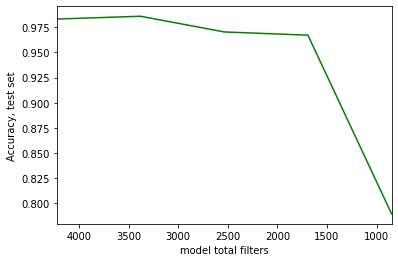

In [10]:
import matplotlib.pyplot as plt
plt.plot(hist["filters"], hist["accuracy_retrained_model"], color='green')
plt.xlabel('model total filters')
plt.ylabel('Accuracy, test set')
plt.xlim(hist["filters"][0], hist["filters"][-1])
#plt.title("")
#plt.legend()
plt.savefig('prunningfiltersvgg16.png')


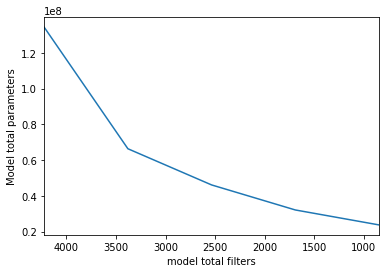

In [12]:
plt.plot(hist["filters"], hist["parameters"])
plt.xlabel('model total filters')
plt.ylabel('Model total parameters')
plt.xlim(hist["filters"][0], hist["filters"][-1])
plt.savefig('parametersvgg16.png')
#plt.ylim(hist["parameters"][0], hist["parameters"][-1])